In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
import glob
import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from mc2.utils.data_inspection import (
    get_available_material_names, get_file_overview, load_and_process_single_from_full_file_overview,
)
from mc2.utils.data_plotting import plot_single_sequence, plot_hysteresis
from mc2.data_management import FrequencySet, MaterialSet, DataSet

## Foundation RNN model based on [Wang2024](https://www.techrxiv.org/users/662665/articles/1250137-magnetx-foundation-neural-network-models-for-simulating-power-magnetics-in-transient)

- Model outline:

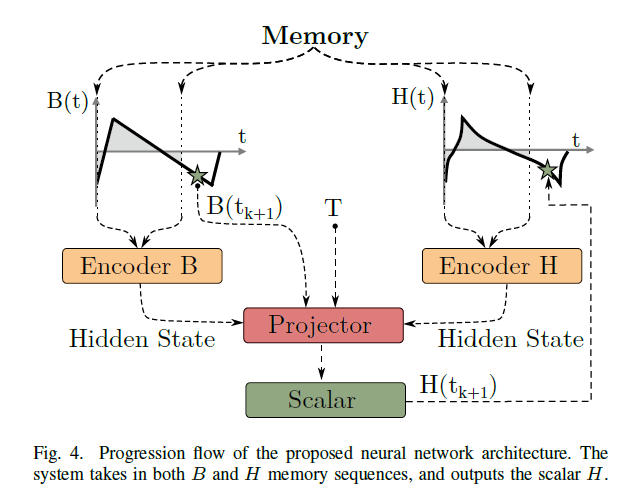

In [ ]:
dataset = DataSet.load_from_file(pathlib.Path("../../data/processed") / "ten_mat_data.pickle")

## deleting N49 from dataset for now, since the data is incomplete
# 50 kHz and 80 kHz are missing
# 320 kHz has no data at 25 degrees

available_materials = deepcopy(dataset.material_names)
print(available_materials)
print(len(available_materials))

available_materials.remove("N49")
print(available_materials)
print(len(available_materials))


dataset = dataset.filter_materials(available_materials)
assert dataset.material_names == available_materials

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

In [ ]:
all_relevant_data = dataset.at_material("3C90").at_frequency(50_000).filter_temperatures([25])
all_relevant_data

training_data = FrequencySet(
    all_relevant_data.material_name,
    all_relevant_data.frequency,
    all_relevant_data.H[:200, :],
    all_relevant_data.B[:200, :],
    all_relevant_data.T[:200],
)

testing_data = FrequencySet(
    all_relevant_data.material_name,
    all_relevant_data.frequency,
    all_relevant_data.H[200:, :],
    all_relevant_data.B[200:, :],
    all_relevant_data.T[200:],
)

In [ ]:
from mc2.training.optimization import make_step
from mc2.training.data_sampling import draw_data_uniformly

In [ ]:
identity = lambda x: x

class FoundationRNN(eqx.Module):

    encoder_hidden_size: int
    
    H_cell: eqx.nn.GRUCell
    B_cell: eqx.nn.GRUCell
    mlp_projector: eqx.nn.MLP

    def __init__(self, in_size, out_size, hidden_size, mlp_width_size, mlp_depth, *, key):

        h_key, b_key, mlp_key = jax.random.split(key, 3)
        self.encoder_hidden_size = hidden_size

        self.H_cell = eqx.nn.GRUCell(in_size, hidden_size, key=h_key)
        self.B_cell = eqx.nn.GRUCell(in_size, hidden_size, key=b_key)
        self.mlp_projector = eqx.nn.MLP(
            in_size=2*hidden_size + 1,  
            out_size=out_size,
            width_size=mlp_width_size,
            depth=mlp_depth,
            activation=jax.nn.leaky_relu,
            final_activation=identity,
            key=mlp_key,
        )

    def prepare_hidden_states(self, past_B_values, past_H_values):
        b_hidden = jnp.zeros((self.encoder_hidden_size,))
        h_hidden = jnp.zeros((self.encoder_hidden_size,))

        def f(carry, inp):
            b_hid, h_hid = carry
            past_b, past_h = inp

            b_hid = self.B_cell(past_b, b_hid)
            h_hid = self.H_cell(past_h, h_hid)
            
            return (b_hid, h_hid), None
        
        (b_hid, h_hid), _ = jax.lax.scan(f, (b_hidden, h_hidden), (past_B_values, past_H_values))
        return b_hid, h_hid

    @eqx.filter_jit
    def simulate(self, past_B_values, past_H_values, next_B_values):
        b_hid, h_hid = self.prepare_hidden_states(past_B_values, past_H_values)
        first_H = self.mlp_projector(jnp.concatenate([b_hid, h_hid, next_B_values[0]]))

        def f(carry, inp):
            b_hid, h_hid, momentary_H, momentary_B = carry
            next_B = inp

            b_hid = self.B_cell(momentary_B, b_hid)
            h_hid = self.H_cell(momentary_H, h_hid)

            pred_H = self.mlp_projector(jnp.concatenate([b_hid, h_hid, next_B]))
            return (b_hid, h_hid, pred_H, next_B), pred_H

        _, out = jax.lax.scan(f, (b_hid, h_hid, first_H, next_B_values[0]), next_B_values[1:])
        return jnp.concatenate([first_H[..., None], out], axis=0)
        
    
    @eqx.filter_jit
    def __call__(self, past_B_values, past_H_values, next_B_value):
        b_hid, h_hid = self.prepare_hidden_states(past_B_values, past_H_values)
        out = self.mlp_projector(jnp.concatenate([b_hid, h_hid, next_B_value]))
        return out

In [ ]:
def test_on_evalset(evaluation_data, model):
    batched_H = evaluation_data.H[:, :][..., None]
    batched_B = evaluation_data.B[:, :][..., None]
    
    sim_H = jax.vmap(model.simulate)(
        batched_B[:, :100, :],
        batched_H[:, :100, :],
        batched_B[:, 100:, :]
    )
    sim_H = jnp.concatenate([batched_H[:, :100, :], sim_H], axis=1)

    for i in range(min(batched_H.shape[0], 5)):
        fig, axs = plot_single_sequence(batched_B[i], batched_H[i], jnp.unique(testing_data.T))
        axs[-1].plot(sim_H[i], label="pred")
        fig.legend()
        plt.show()

In [ ]:
# # loss computation as described in the Wang2025 paper
# # performs very poorly for simulation, but decent for prediction
# 
# @eqx.filter_value_and_grad
# def compute_MSE_loss(model: eqx.Module, B: jax.Array, H: jax.Array) -> jax.Array:
#     """Computes the mean squared error between the model predictions and the given ground truth values.

#     This function is decorated with `@eqx.filter_value_and_grad` to enable automatic differentiation.
#     The batch dimension is expected to be the first dimension of the input data and it is dealt with
#     by using `jax.vmap` to vectorize the model evaluation across the batch.

#     Args:
#         model(eqx.Module): The model to be evaluated.
#         B(jax.Array): Input data (will generally be B values).
#         H(jax.Array): Ground truth values (will generally be H values).
#     """
#     pred_H = jax.vmap(model)(B[:, :-1, :], H[:, :-1, :], B[:, -1, :])
#     return jnp.mean((pred_H - H[:, -1:, 0]) ** 2)

@eqx.filter_value_and_grad
def compute_MSE_loss(model: eqx.Module, memory_B: jax.Array, memory_H: jax.Array, future_B: jax.Array, future_H: jax.Array) -> jax.Array:

    pred_H = jax.vmap(model.simulate)(memory_B, memory_H, future_B)
    return jnp.mean((pred_H - future_H) ** 2)


@eqx.filter_jit
def make_step(
    model: eqx.Module, B: jax.Array, H: jax.Array, optim: optax.GradientTransformation, opt_state: optax.OptState, memory_length: int
):
    """Performs a single optimization step.

    This function computes the gradients of the MSE loss with respect to the model parameters,
    updates the model parameters using the optimizer, and returns the updated model and optimizer state.
    Args:
        model(eqx.Module): The model to be optimized.
        B(jax.Array): Input data (will generally be B values).
        H(jax.Array): Ground truth values (will generally be H values).
        optim(optax.GradientTransformation): The optimizer to be used.
        opt_state(optax.OptState): The current state of the optimizer.

    Returns:
        Tuple[jax.Array, eqx.Module, optax.OptState]: The loss value, updated model, and updated optimizer state.
    """

    assert memory_length + prediction_length == B.shape[1]
    assert memory_length + prediction_length == H.shape[1]

    memory_B = B[:, :memory_length]
    memory_H = H[:, :memory_length]

    future_B = B[:, memory_length:]
    future_H = H[:, memory_length:]
    
    loss, grads = compute_MSE_loss(model, memory_B, memory_H, future_B, future_H)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
n_sequences, full_sequence_length = training_data.H.shape
training_batch_size = 64

memory_length = 100
prediction_length = 5_000

sequence_length = memory_length + prediction_length


key = jax.random.key(4141)
key, model_key, loader_key = jax.random.split(key, 3)

model = FoundationRNN(1, 1, 256, 128, 4, key=model_key)


lr = optax.schedules.exponential_decay(
    init_value=1e-3,
    transition_steps=20_000,
    transition_begin=2_000,
    decay_rate=0.995,
    end_value=1e-4
)

# lr = 1e-4

optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

In [ ]:
losses = []

for step in tqdm.tqdm(range(5_000)):
    
    batched_H, batched_B, loader_key = draw_data_uniformly(training_data, sequence_length, training_batch_size, loader_key)
    loss, model, opt_state = make_step(model, batched_B, batched_H, optim, opt_state, memory_length)    
    losses.append(loss)

    if step % 1000 == 0 and step > 0:
        plt.suptitle(f"Training loss over training steps at {step} steps")
        plt.plot(np.log(losses))
        plt.show()

        test_on_evalset(testing_data, model)

How heavily is the loss dominated by the spikes?

### Simulation mode

- according to the paper, the models are trained in prediction mode, but this is really bad for the simulation performance

In [ ]:
batched_H = testing_data.H[:, :][..., None]
batched_B = testing_data.B[:, :][..., None]

sim_H = jax.vmap(model.simulate)(
    batched_B[:, :100, :],
    batched_H[:, :100, :],
    batched_B[:, 100:, :]
)
sim_H = jnp.concatenate([batched_H[:, :100, :], sim_H], axis=1)

In [ ]:
sim_H

In [ ]:
for i in range(min(batched_H.shape[0], 20)):
    fig, axs = plot_single_sequence(batched_B[i], batched_H[i], jnp.unique(testing_data.T))
    axs[-1].plot(sim_H[i], label="pred")
    fig.legend()

### prediction mode:

Here, the prediction model performs better than the simulation model.
Makes sense but what do we need?


In [ ]:
batched_H = testing_data.H[:, :][..., None]
batched_B = testing_data.B[:, :][..., None]

pred_H = []

for i in tqdm.tqdm(range(batched_H.shape[1])):
    pred_H.append(jax.vmap(model)(batched_B[:, (i-100):(i-1), :], batched_H[:, (i-100):(i-1), :], batched_B[:, i, :]))

pred_H = jnp.hstack(pred_H)[..., None]

In [ ]:
for i in range(min(batched_H.shape[0], 20)):
    fig, axs = plot_single_sequence(batched_B[i], batched_H[i], jnp.unique(testing_data.T))
    axs[-1].plot(pred_H[i], label="pred")
    fig.legend()

In [ ]:
for i in range(min(batched_H.shape[0], 20)):
    fig, axs = plot_hysteresis(batched_B[i], batched_H[i], jnp.unique(testing_data.T)) 
    fig, axs = plot_hysteresis(batched_B[i], pred_H[i], jnp.unique(testing_data.T), fig=fig, axs=axs)
    fig.legend()